This example conducts a statistical analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on April 15, 2020.

In [119]:
import csv
import datetime
import random
import sys
import time

import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [88]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_041420_10am.csv', parse_dates=['start_date'], date_parser=dateparse)

In [89]:
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,6.022000e+23,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2.034423e+03,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,6.022000e+23,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,6.022000e+23,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,6.022000e+23,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
397,2011-10-12,16,4,5,2,12,14,1,7.784568e+02,02h 26m 46s
398,2011-08-12,16,4,5,4,2,14,1,6.022000e+23,00h 00m 00s
399,2011-10-26,5,4,7,1,12,7,1,6.022000e+23,00h 00m 00s
400,2011-01-12,18,5,4,7,9,99,1,9.809773e+02,02h 34m 53s


In [90]:
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2034.423190,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
397,2011-10-12,16,4,5,2,12,14,1,778.456764,02h 26m 46s
398,2011-08-12,16,4,5,4,2,14,1,NaN,00h 00m 00s
399,2011-10-26,5,4,7,1,12,7,1,NaN,00h 00m 00s
400,2011-01-12,18,5,4,7,9,99,1,980.977345,02h 34m 53s


In [324]:
data.sort_values(by='fitness')

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
190,2011-12-13,1,5,1,1,8,5,2,390.165664,01h 37m 48s
261,2011-10-22,11,4,3,4,12,14,1,476.201941,03h 23m 58s
308,2011-10-22,21,4,2,4,8,93,1,477.317459,01h 07m 36s
312,2011-12-21,11,4,3,4,8,14,1,478.945832,02h 01m 17s
271,2011-01-31,1,4,3,4,8,93,1,484.518774,00h 47m 28s
...,...,...,...,...,...,...,...,...,...,...
191,2011-12-17,18,4,4,7,2,93,1,NaN,00h 00m 10s
99,2011-12-19,50,1,24,7,7,14,1,NaN,06h 00m 03s
338,2011-12-25,15,7,3,5,9,7,1,NaN,00h 00m 00s
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00


In [136]:
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
37,2011-01-01,8,4,99,5,9,7,1,1432.446184,5:22:22.863760
33,2011-01-01,18,3,4,7,9,7,1,NaN,6:00:02.341057
203,2011-01-01,6,5,99,7,9,1,1,NaN,06h 00m 08s
361,2011-01-02,6,1,4,4,12,16,1,630.713944,01h 14m 12s
305,2011-01-02,11,4,4,2,12,5,1,710.210094,03h 44m 48s
...,...,...,...,...,...,...,...,...,...,...
129,2011-12-27,17,7,1,2,7,1,1,1033.922806,02h 16m 35s
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
108,2011-12-30,2,4,24,5,9,94,1,890.534170,05h 09m 23s
5,2011-12-30,6,31,1,7,5,2,1,1363.634615,1:55:58.395966


In [186]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)
    
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

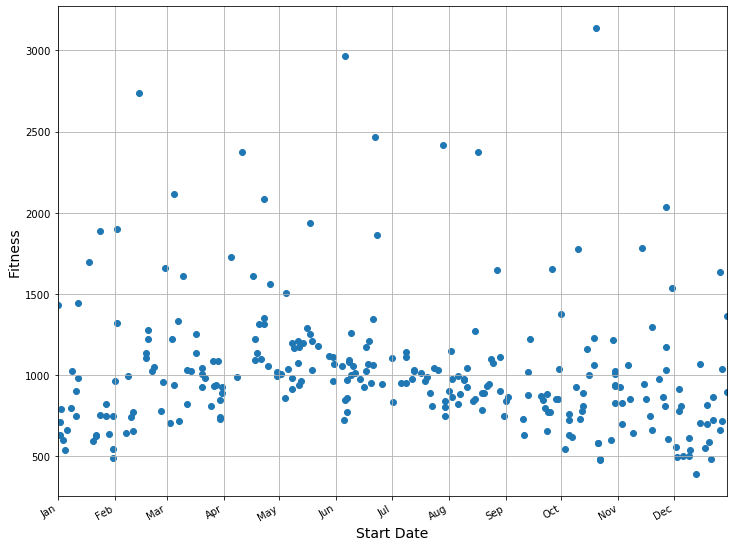

In [187]:
# Plot start_date vs fitness
start_date = data.start_date
fitness = data.fitness

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(start_date, fitness)
format_plot('Start Date', 'Fitness')

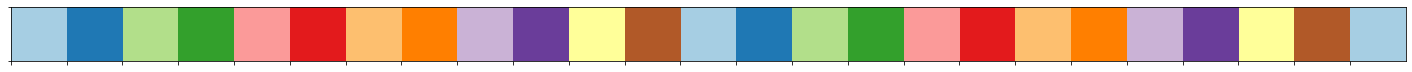

In [247]:
cmap1 = sns.color_palette('Paired',25)
sns.palplot(cmap1)

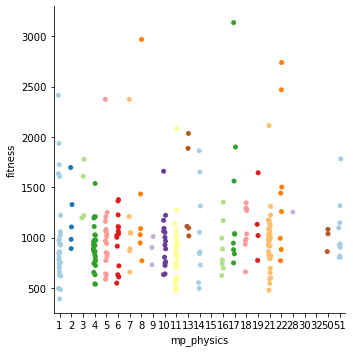

In [238]:
# Plot microphysics option vs. fitness
sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1);

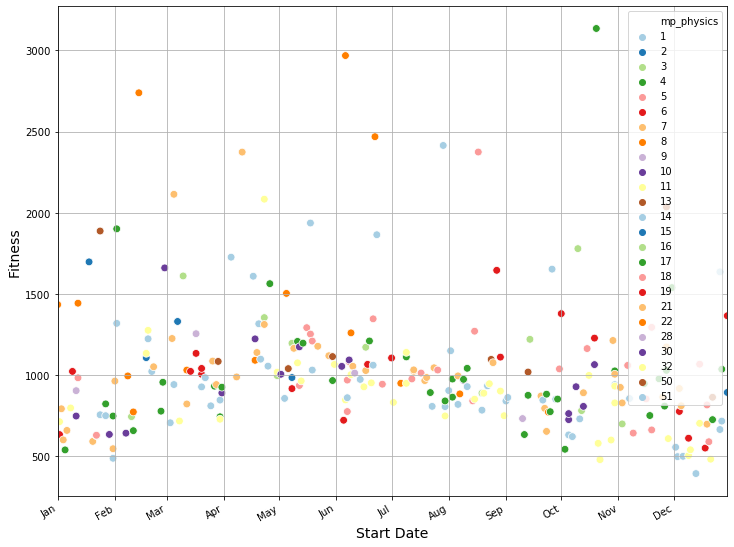

In [239]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')

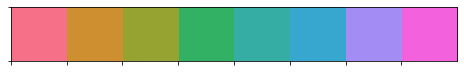

In [244]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

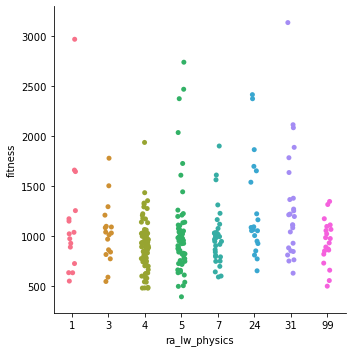

In [248]:
# Plot longwave radiation option vs. fitness
sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2);

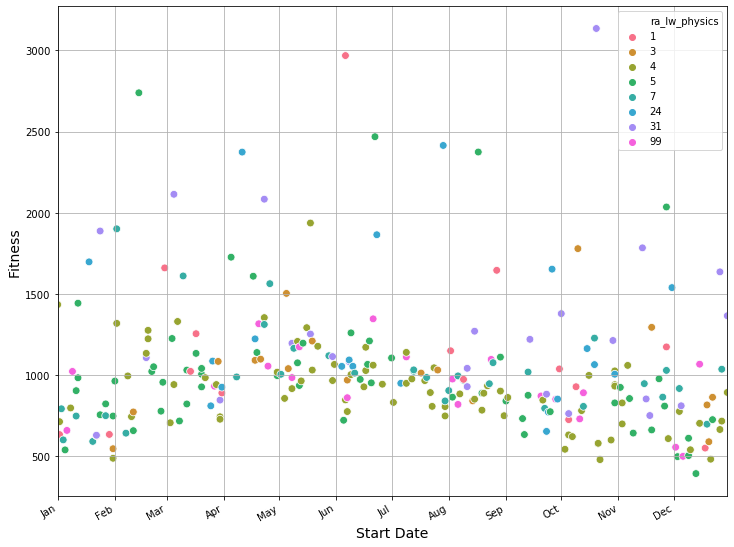

In [249]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')

In [190]:
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

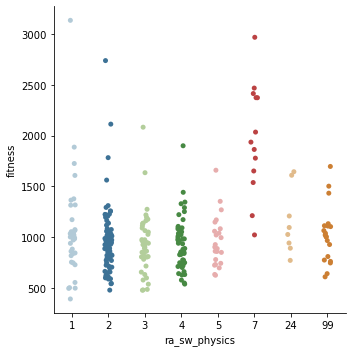

In [250]:
# Plot shortwave radiaiton option vs. fitness
sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3);

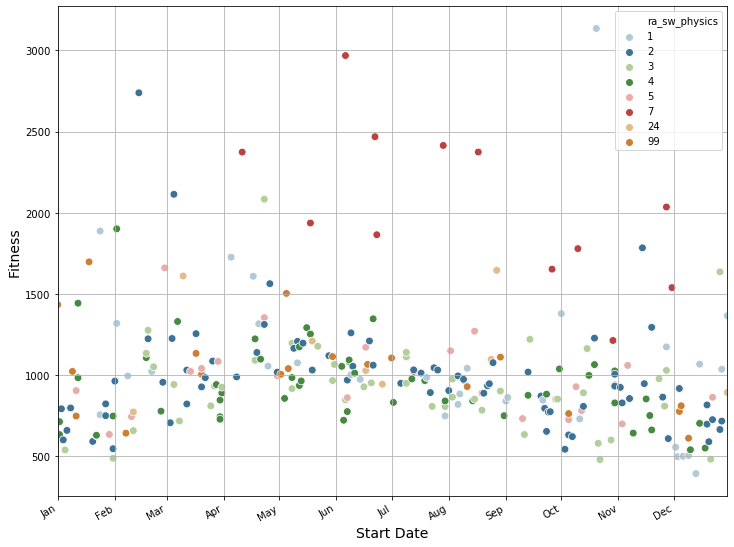

In [195]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')

In [251]:
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

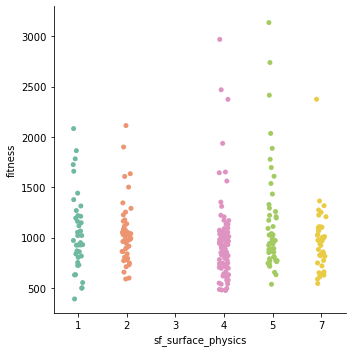

In [252]:
# Plot surface physics option vs. fitness
sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4);

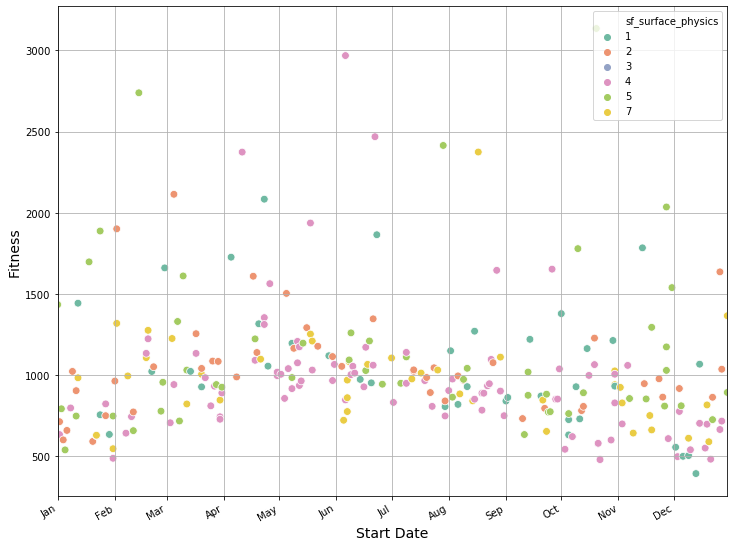

In [253]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')

In [254]:
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

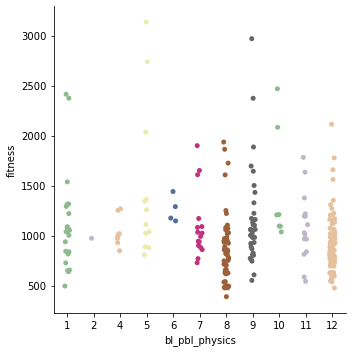

In [258]:
# Plot planetary boundary layer option vs. fitness
sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5);

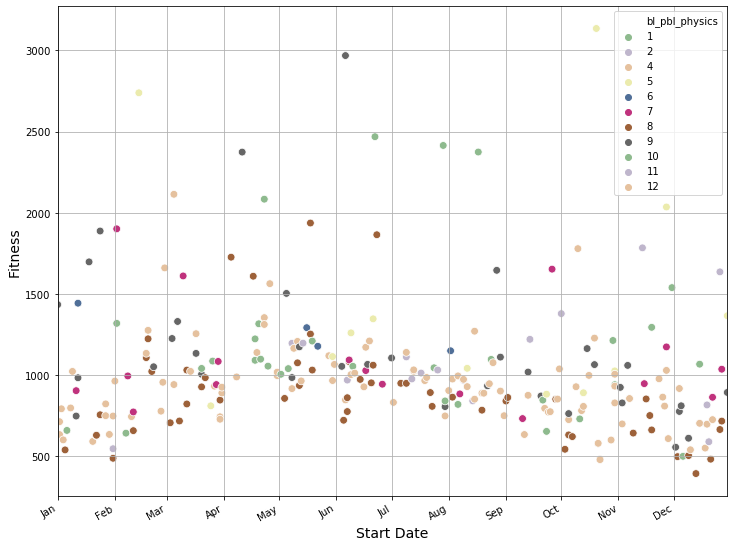

In [260]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')

In [261]:
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

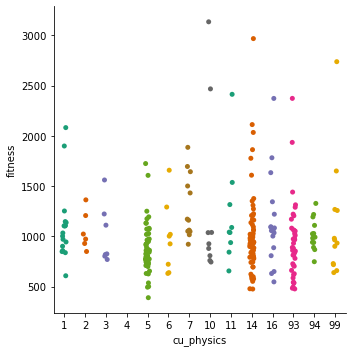

In [263]:
# Plot cumulus option vs. fitness
sns.catplot(x='cu_physics', y='fitness', data=data, palette=cmap6);

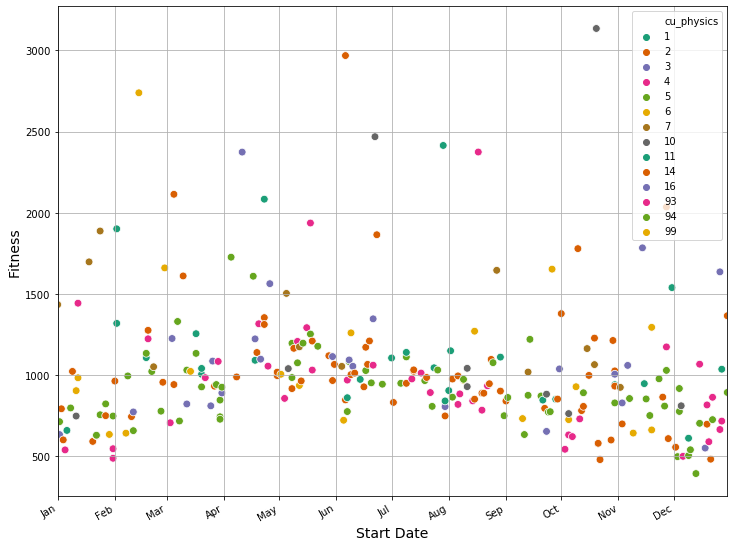

In [266]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')

In [267]:
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

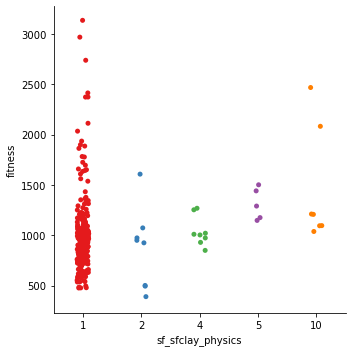

In [270]:
# Plot surface layer option vs. Fitness
sns.catplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)

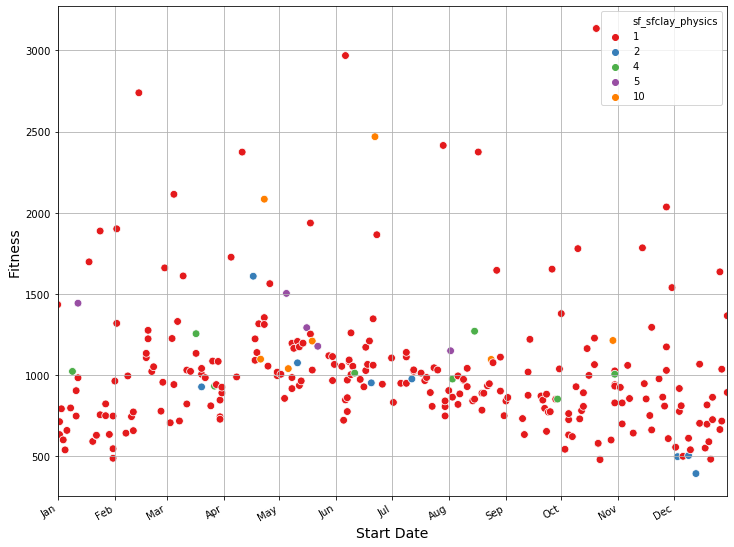

In [271]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')

Text(0, 0.5, 'Fitness')

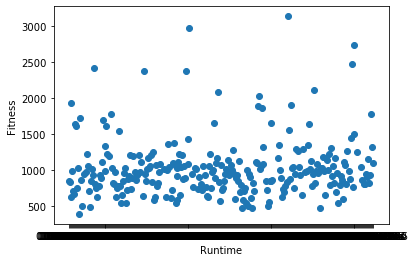

In [131]:
# Plot start_date vs fitness
data = data.sort_values(by='mp_physics')
runtime = data.runtime
fitness = data.fitness

fig, ax = plt.subplots()
plt.scatter(runtime, fitness)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

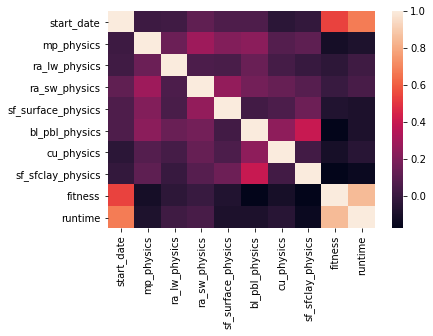

In [322]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)

In [ ]:
# # Create more detailed heatmaps
# ra_data = data[['ra_lw_physics', 'ra_sw_physics', 'fitness']]
# ra_data

# temp = ra_data.drop(columns=['ra_sw_physics'])
# temp = temp.groupby('ra_lw_physics').mean()
# temp

# temp = ra_data.drop(columns=['ra_lw_physics'])
# temp = temp.groupby('ra_sw_physics').mean()
# temp